In [1]:
from fastai import *
from fastai.vision.all import *
from models import conv, deconv

import sys
sys.path.append('..')
from src.band_plotters import *
from src.Tiff32Image import Tiff32Image, Tiff32ImageNoised, AddNoiseTransform, RandomEraseTransform

In [2]:
NUMBER_OF_NEAR_BANDS = 12
SELECTED_WIDTH = 128

# from save_autoencoder_images:
MAX_ENERGY_MINUS_EFERMI =  20 # actually 30 but only 1 material exceeds 20
MIN_ENERGY_MINUS_EFERMI =  -17 # actually -100 but only 2 materials exceed -22 

## Load

In [18]:
class RandomErasingBWInput(RandomErasing):
    def encodes(self,x:TensorImageNoised):
        count = random.randint(1, self.max_count)
        _,img_h,img_w = x.shape[-3:]
        area = img_h*img_w/count
        areas = [self._bounds(area, img_h, img_w) for _ in range(count)]
        return cutout_gaussian(x, areas)

In [19]:
dls = DataBlock(
    blocks=(ImageBlock(cls=Tiff32Image), ImageBlock(cls=Tiff32Image)), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1),
    item_tfms=[Resize((12, SELECTED_WIDTH), "squish"), RandomErasingBWInput()], #AddNoiseTransform(std=1000)],
    batch_tfms=[IntToFloatTensor(div=2**16-1),],
        ).dataloaders(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands", bs=64)

dls.show_batch()

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


IndexError: tuple index out of range

## Train

### Create Learner

In [4]:
from models import conv, deconv

class SimpleAutoencoder(nn.Module):
    def __init__(self, n_latent=128, norm=False):
        super().__init__()
        self.encode = nn.Sequential(
            conv(1, 4, norm=norm), # 6x64
            conv(4, 8, norm=norm), # 3x32
            nn.Flatten(),
            nn.Linear(3*32*8, n_latent),
            nn.Tanh(),
        )
        
        self.decode_linear=nn.Sequential(
            nn.Linear(n_latent, 8*3*32),
            nn.BatchNorm1d(8*3*32),
            nn.ReLU(),
        )
        
        self.decode = nn.Sequential(
            deconv(8, 4, norm=norm), # 6x64
            deconv(4, 1, norm=norm, act=False), # 12x128
            nn.Sigmoid()
        )
        
    
    def forward(self, x):
        out = self.encode(x)
        out = self.decode_linear(out)
        out = out.view(-1, 8, 3, 32)
        return self.decode(out)

epoch,train_loss,valid_loss,time
0,0.002078,0.003244,00:07


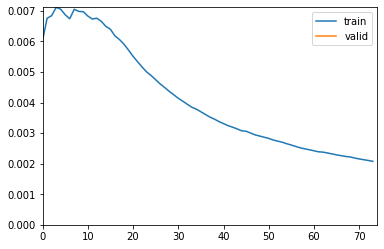

In [5]:
ae = SimpleAutoencoder(n_latent=256)
learn = Learner(dls, ae, F.mse_loss, cbs=[ShowGraphCallback()])
learn.fit_one_cycle(1)

## View Predictions

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


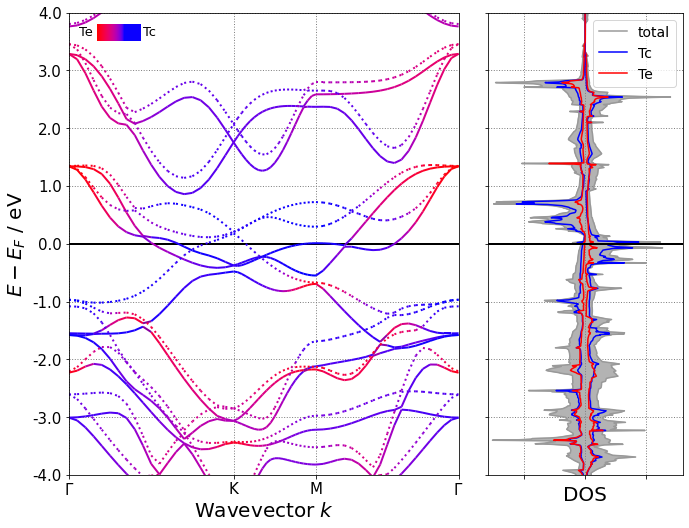

In [6]:
plot("2dm-7")

array([<AxesSubplot:title={'center':'Input'}>,
       <AxesSubplot:title={'center':'Reconstruction'}>], dtype=object)

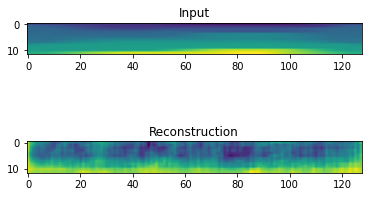

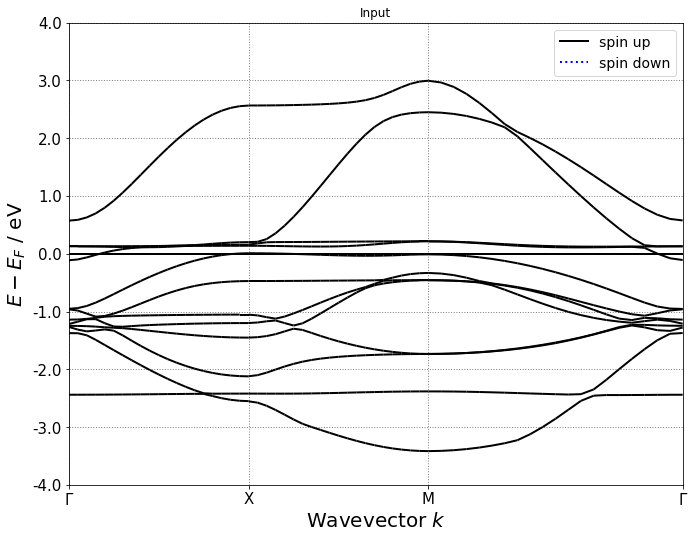

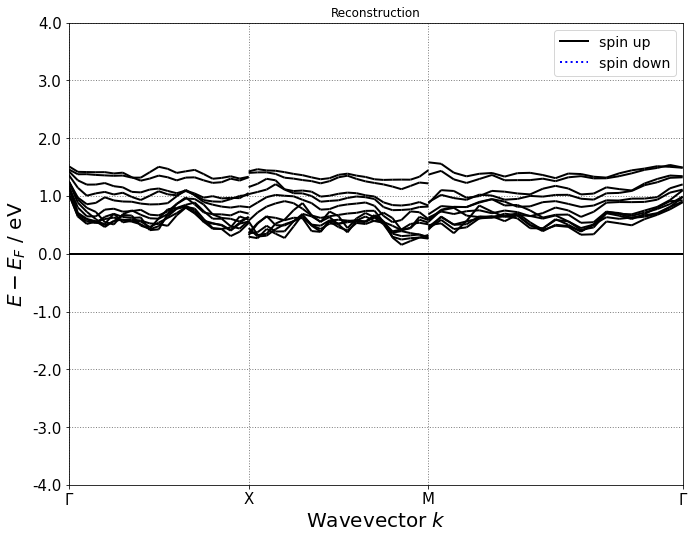

In [7]:
view_prediction("2dm-25", learn.model, MIN_ENERGY_MINUS_EFERMI, MAX_ENERGY_MINUS_EFERMI, width=SELECTED_WIDTH)

In [8]:
# learn.export("trained_models/nearest_12_v1.pkl")

In [12]:
from torchvision.transforms import RandomErasing
o = Tiff32Image.create(DATA_DIRECTORY/f"images/energies_{NUMBER_OF_NEAR_BANDS}_nearest_bands"/"2dm-1.tiff")
x, y, h, w, v = RandomErasing.get_params(o, scale=0.5, ratio=(0.3, 3.3), value=0)
    # return F.erase(o, x, y, h, w, v)

IndexError: tuple index out of range